# Artifical Neural Network

In [1]:
import numpy as np
seed = 42
rng = np.random.default_rng(seed = seed)

## Network Class

1. The network class has the following two methods
- `fit`
- `predict`

2. Fitting the neural network requires us for the follwing procedures:
- `forward`
- `backward`

3. We need to initialize all the parameters in the follwing manner:
- `init`

4. We need to use some helper functions like:
- `activations`
- `losses`

The flow of program code will be as follows:
- `helpers -> init -> forward -> backward -> fit -> predict`

In [2]:
class Network:
  def init(self,layers,activation='relu',ouput_choice='softmax',loss_choice='cce'):
    pass

  def forward(self,X):
    pass

  def backward(self,y,y_hat):
    pass

  def fit(self,X,y,lr=0.01,epochs=100,batch_size=100):
    pass

  def predict(self,X):
    pass

## Activation Function

### Sigmoid

$$g(z) = \frac{1}{1+e^{-z}}$$

### ReLU

$$
\begin{array}{cc}
  \{ & 
    \begin{array}{cc}
      z & z\geq 0 \\
      0 & otherwise
    \end{array}
\end{array}
$$

In [3]:
def sigmoid(z):
  return 1/(1 + np.exp(-z))

def grad_sigmoid(z):
  return sigmoid(z)*(1 - sigmoid(z))

def relu(z):
  return np.where(z>=0,z,0)

def grad_relu(z):
  return np.where(z>=0,1,0)

hidden_act = {'sigmoid':sigmoid,'relu':relu}
grad_hidden_act = {'sigmoid': grad_sigmoid,'relu':grad_relu}

## Output layer

1. For regression we will use **identity function** for output
$$g(z) = z$$

2. For classification we will require the **softmax function**

$$g(z) = \frac{e^{Z_{ij}}}{∑ e^{Z_{ij}}}$$

In [5]:
def identity(z):
  return z
def softmax(z):
  assert z.ndim ==2
  z -= z.max(axis = 1,keepdims = True)

  prob = np.exp(z)/np.exp(z).sum(axis = 1,keepdims=True)

  assert np.allclose(prob.sum(axis = 1),np.ones(z.shape[0]))

  return prob

output_act = {'identity': identity,'softmax':softmax} 

## Loss

### Least Square for Regression

$$L(y,y_{hat}) = \frac{1}{2}(y_{hat} - y)^{T}(y_{hat} - y)$$

### Categorical CrossEntropy for Classification

$$L(Y,𝕐) = -1^{T}_{n}(Y ⊙ np.log(𝕐))1_{k}$$

In [6]:
def least_sqaure(y,y_hat):
  return 0.5*(np.sum((y_hat - y) * (y_hat - y)))


def cce(y,y_hat):
  return -np.sum(y*np.log(y_hat))

losses = {'least_sqaure':least_sqaure,'cce':cce}

## Network Initialization
Here we take care of two things

1. Network Initialziation
2. Weight Initialization

In [7]:
def count_params(layers):
  num_params = 0

  for l in range(1,len(layers)):
    num_weights = layers[l-1]*layers[l]
    num_biases = layers[l]
    num_params += (num_weights+num_biases)
  return num_params

## Parameter Iniitalziation

The weight matrix at the layer l is of the size `layers[l-1] X layers[l]`

The bias at the layer l is of the shape `layer[l]`

In [28]:
def init_param(layers):
  num_params = count_params(layers)
  W = [None for _ in range(len(layers))]
  b = [None for _ in range(len(layers))]

  gW = [None for _ in range(len(layers))]
  gb = [None for _ in range(len(layers))]

  thetha = rng.standard_normal(num_params)
  gthehta = np.zeros(num_params)

  start,end = 0,0
  for l in range(1,len(layers)):
    end  = start + layers[l-1]*layers[l]
    W[l] = thetha[start:end].reshape(layers[l-1],layers[l])
    gW[l] = gthehta[start:end].reshape(layers[l-1],layers[l])

    start,end = end,end+layers[l]

    b[l] = thetha[start:end].reshape(layers[l])
    gb[l] = gthehta[start:end].reshape(layers[l])

    start = end
  return thetha,gthehta,W,b,gW,gb

In [14]:
def init(self,layers,activation_choice='relu',
         output_choice = 'softmax',loss_choice='cce'):
  self.layers = layers

  #Parameters and gradients
  self.thetha,self.gthehta,\
  self.W,self.b,\
  self.gW,self.gb = init_param(layers)

  #Activation Functions
  self.ghid = hidden_act[activation_choice]
  self.grad_ghid = grad_hidden_act[activation_choice]
  self.gout = output_act[output_choice]

  #Loss
  self.loss = losses[loss_choice]

## Forward Pass

In [9]:
def forward(self,X):
  self.A = [None for _ in range(len(self.layers))]
  self.Z = [None for _ in range(len(self.layers))]

  self.A[0] = X
  self.Z[0] = X
  
  for l in range(1,len(self.layers)):
    self.Z[l] = self.A[l-1]@self.W[l] + self.b[l]
    self.A[l] = self.ghid(self.Z[l])

  self.A[-1] = self.gout(self.Z[-1])

  return self.A[-1]

## Backward Pass

In [10]:
def backward(self,y,y_hat):
  gZ = [None for _ in range(len(self.layers))]
  gA = [None for _ in range(len(self.layers))]

  gZ[-1] = y_hat - y

  for l in range(len(self.layers)-1,0,-1):
    self.gW[l][:,:] = self.A[l-1].T @ gZ[l]
    self.gb[l][:] = np.sum(gZ[l].T,axis = 1)
    gA[l-1] = gZ[l]@self.W[l].T
    gZ[l-1] = gA[l-1]*self.grad_ghid(self.Z[l-1])

In [11]:
def fit(self,X,y,lr=0.01,epochs=100,batch_size=100):
  self.losses = []

  for epochs in range(epochs):
    y_hat = self.forward(X)
    self.losses.append(self.loss(y,y_hat))
    indices = np.arange(X.shape[0])

    rng.shuffle(indices)
    X,y = X[indices],y[indices]

    num_batches = X.shape[0]//batch_size

    # Mini batch Gradient Descent
    for b in range(num_batches):
      Xb = X[b*batch_size:(b+1)*batch_size]
      yb = y[b*batch_size:(b+1)*batch_size]

      y_hat_b = self.forward(Xb)
      self.backward(yb,y_hat_b)

      self.thetha -= lr*self.gthehta

## Predict

In [12]:
def predict(self,X):
  y_hat = self.forward(X)

  if X.shape[-1]==1:
    return y_hat
  else:
    return np.argmax(y_hat,axis = 1)


In [15]:
Network.__init__ = init
Network.forward = forward
Network.backward = backward
Network.fit = fit
Network.predict = predict

(1797, 64)


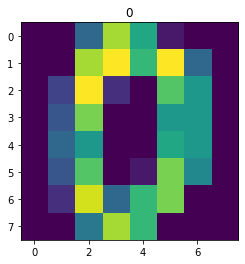

In [20]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
digits = load_digits()

X = digits.images
X /= np.max(X)
y = digits.target

plt.imshow(X[0])
plt.title(y[0])

X = X.reshape(-1,64)

print(X.shape)

In [21]:
def onehotencoder(y):
  k = len(np.unique(y))

  return np.eye(k)[y]

In [22]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.4,random_state=seed)

y_train = onehotencoder(y_train)
y_test = onehotencoder(y_test)

print('Training data shape',X_train.shape,y_train.shape)
print("Test data shape",X_test.shape,y_test.shape)

Training data shape (1078, 64) (1078, 10)
Test data shape (719, 64) (719, 10)


In [29]:
layers = [64,32,10]
network = Network(layers,activation_choice='sigmoid',output_choice='softmax',loss_choice='cce')
epochs = 50
network.fit(X_train,y_train,lr=0.01,epochs=epochs,batch_size = 10)

Text(0, 0.5, 'CCE')

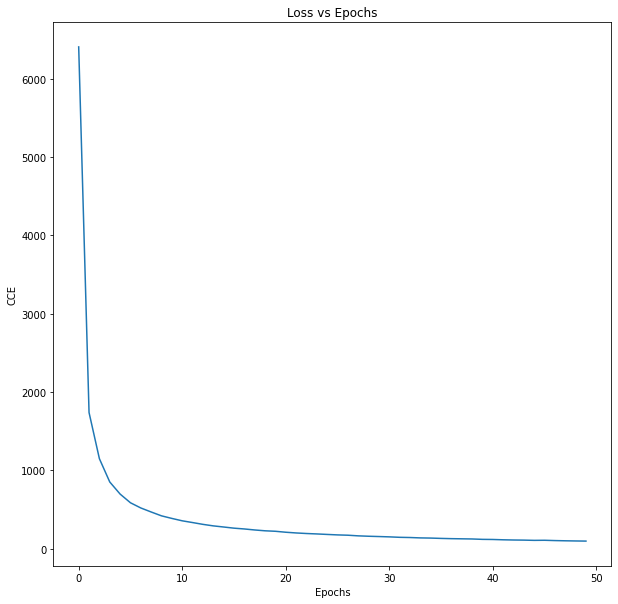

In [30]:
plt.figure(figsize=(10,10))
plt.plot(range(epochs),network.losses)
plt.title('Loss vs Epochs')
plt.xlabel("Epochs")
plt.ylabel("CCE")